In [1]:
# Want to track the dow jones and use indicators
# from: https://medium.com/fintechexplained/automating-stock-investing-technical-analysis-with-python-81c669e360b2
# MACD
# Calculate the MACD line: 
"""
Calculate the 26-day exponentially weighted moving average of the price. This is the long term line.
Calculate the 12-day exponentially weighted moving average of the price. This is the short term line.
Calculate the difference between the 26-day EMA and 12-day EMA lines. This is the MACD line.
"""
# Calculate the Signal line from the MACD line:
"""
Calculate the 9 days exponentially weighted moving average of the MACD line. This is known as the signal line.
We can then calculate the difference between the MACD and the Signal line and then plot it as a histogram. 
The histogram can help us find when the cross-over is about to happen.
"""
# RSI
"""
The calculation is extremely simple.
Firstly, we have to determine the time period. Usually, a 14 day time period is chosen but it could depend on the investor’s own view of the market and the stock.
Secondly, we have to compute the relative strength which is known as RS. RS is the average gain over the average loss. To explain it further, RS is the average gain when the price was moving up over the average loss when the price change was negative.
Calculate RSI as 100 — (100/(1+RS))
The RSI value is between 0–100
"""
# Bollinger Bands
"""
Middle band: Calculate the moving average of the price, usually 20 days moving average.
Upper band: Calculate two standard deviations above the moving average.
Lower band: Calculate two standard deviations below the moving average.
"""

'\nMiddle band: Calculate the moving average of the price, usually 20 days moving average.\nUpper band: Calculate two standard deviations above the moving average.\nLower band: Calculate two standard deviations below the moving average.\n'

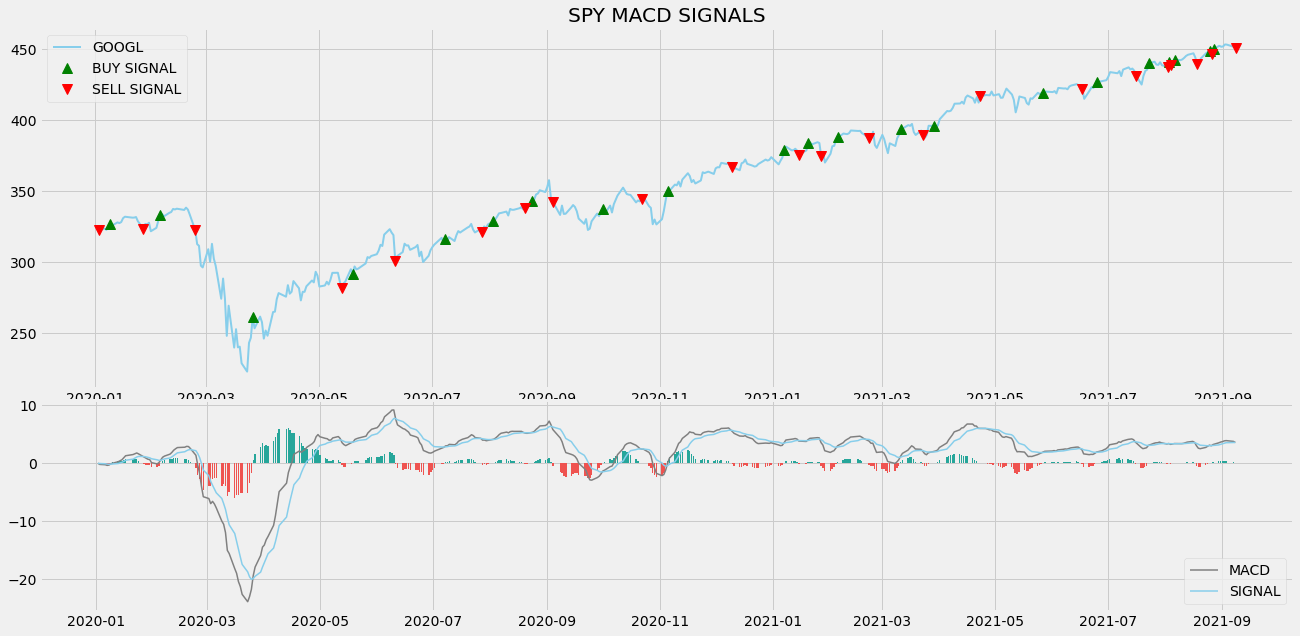

In [8]:
# MACD
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

def get_historical_data(symbol, start_date = None):
    api_key = '00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('SPY', '2020-01-01')
googl


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(googl['close'], 26, 12, 9)
googl_macd.tail()

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(googl['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(googl['close'], googl_macd)

ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(googl['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(googl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(googl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('SPY MACD SIGNALS')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(googl_macd)):
    if str(googl_macd['hist'][i])[0] == '-':
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

              open    high       low   close   adj close      volume
2020-01-02  323.54  324.89  322.5300  324.87  316.709584  59037072.0
2020-01-03  321.16  323.64  321.1000  322.41  314.311377  77708081.0
2020-01-06  320.49  323.73  320.3600  323.64  315.510480  55596982.0
2020-01-07  323.02  323.54  322.2400  322.73  314.623339  40461249.0
2020-01-08  322.94  325.78  322.6700  324.45  316.300134  68177241.0
...            ...     ...       ...     ...         ...         ...
2021-09-01  452.56  453.11  451.5450  451.80  451.800000  48721378.0
2021-09-02  453.32  454.05  451.9100  453.19  453.190000  42830867.0
2021-09-03  451.98  453.63  451.5500  453.08  453.080000  47234364.0
2021-09-07  452.71  452.81  450.7423  451.46  451.460000  51671534.0
2021-09-08  450.89  451.67  448.8600  450.91  450.910000  54693813.0

[425 rows x 6 columns]
              open    high       low   close   adj close      volume  \
2020-01-08  322.94  325.78  322.6700  324.45  316.300134  68177241.0   
2020

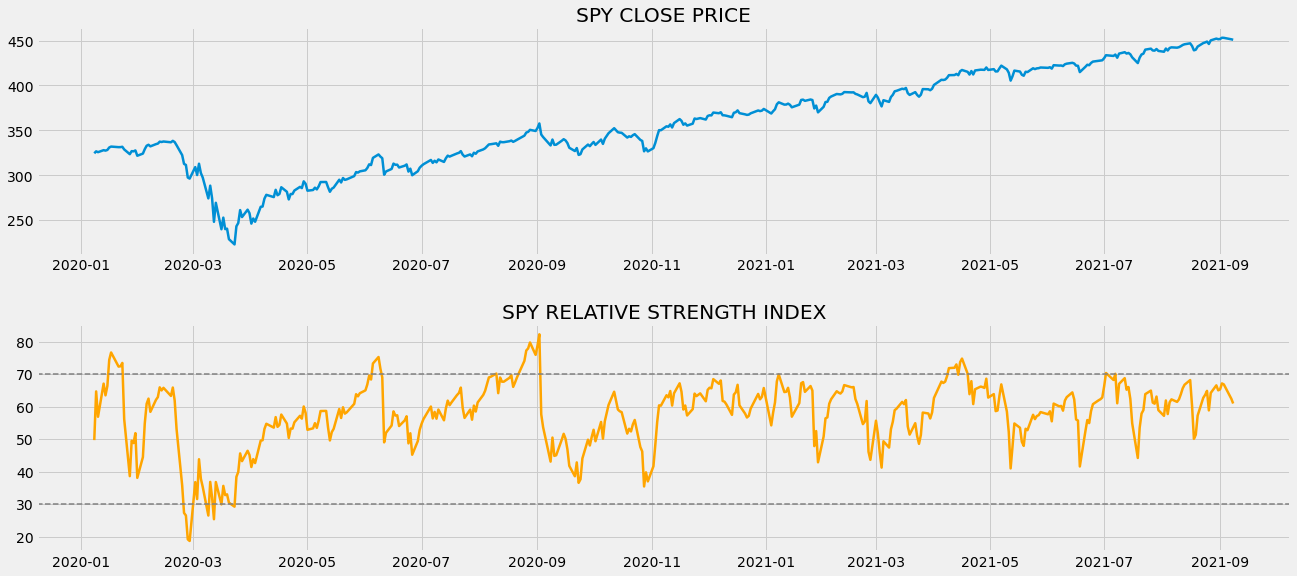

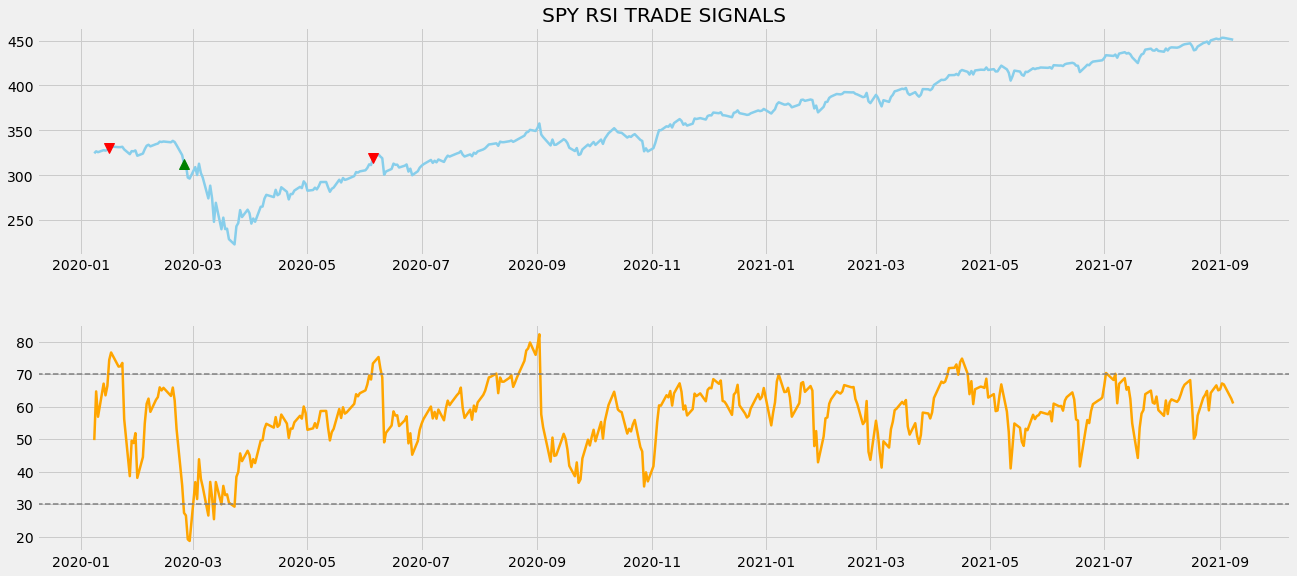

             close     rsi_14  rsi_signal  rsi_position
2020-01-08  324.45  49.695698           0             1
2020-01-09  326.65  64.660091           0             1
2020-01-10  325.71  56.874976           0             1
2020-01-13  327.95  67.054540           0             1
2020-01-14  327.45  63.454017           0             1
Profit gained from the RSI strategy by investing $100k in IBM : 2908.36
Profit percentage of the RSI strategy : 2%


In [11]:
# RSI
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

def get_historical_data(symbol, start_date = None):
    api_key = '00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('SPY', '2020-01-01')
print(ibm)

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
print(ibm)

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('SPY CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('SPY RELATIVE STRENGTH INDEX')
plt.show()

def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('SPY RSI TRADE SIGNALS')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

print(strategy.head())

ibm_ret = pd.DataFrame(np.diff(ibm['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in IBM : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

FX
---
Data loaded: 2586 rows


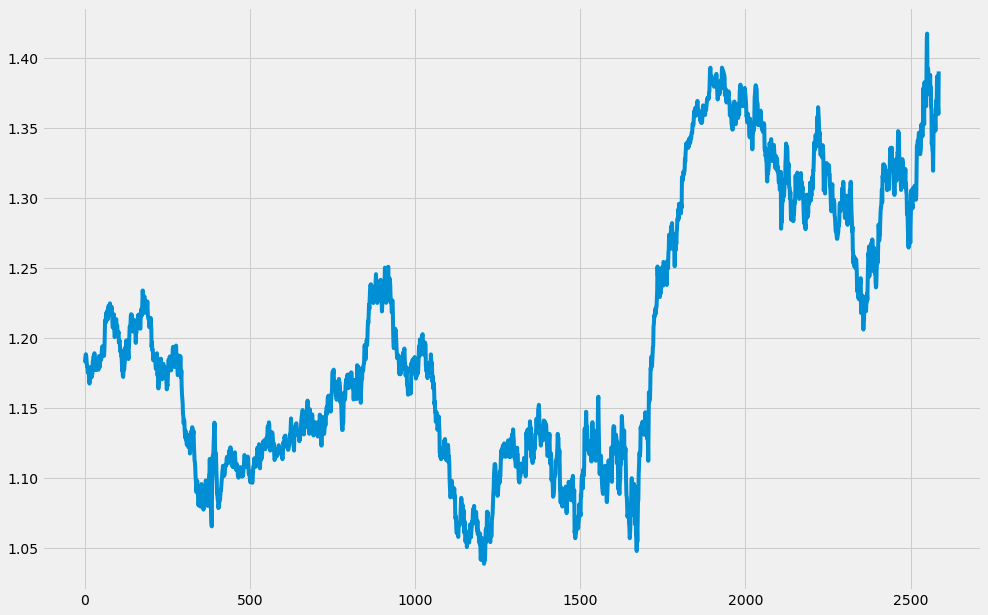

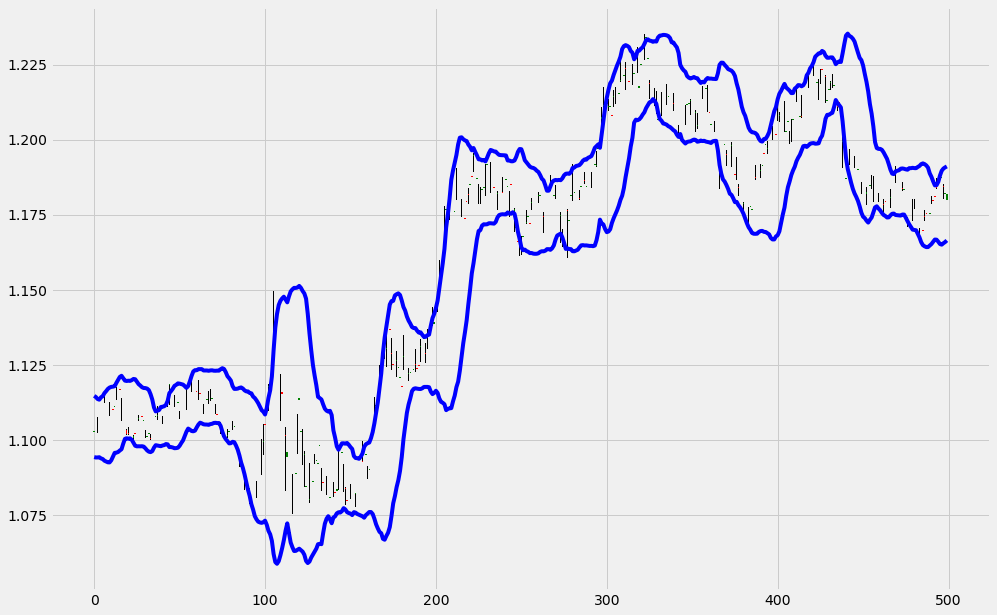

Total bars: 2586
Deviation 2
Inside: 89.33%
Up side: 5.1%
Down side: 4.83%


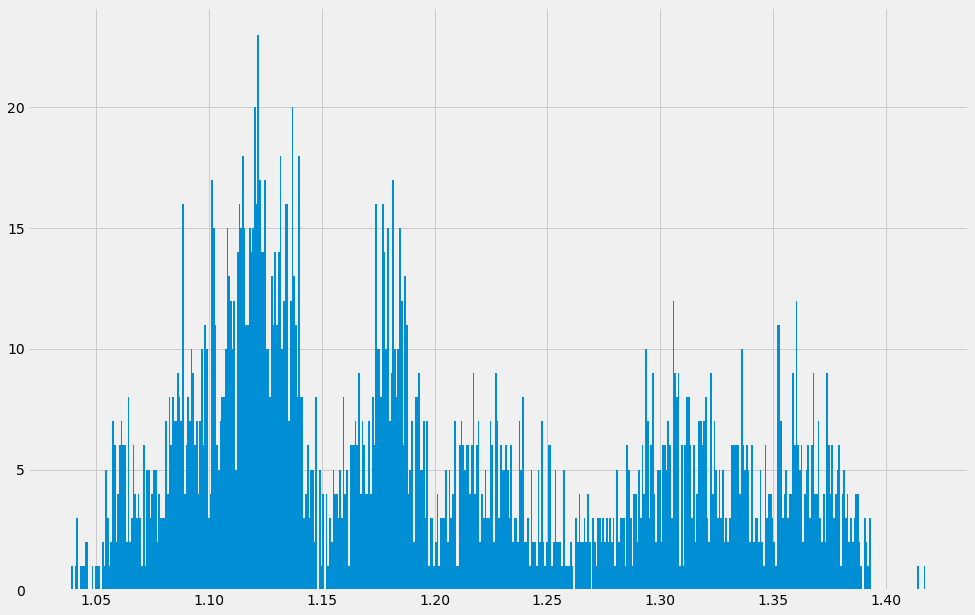

In [21]:
# Bollinger Bands

import requests
import pandas as pd
import matplotlib.pyplot as plt

def load_data(sym="EUR", to_sym="USD", interval="5min", dtype=2, intraday=False, outputsize="full"):
    key = "00f83bac51mshba5c44255841b11p11d607jsnf6d25aeeaebe"
    if dtype == 1: # Download stock
        if intraday:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&interval={}&symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, key, outputsize)
    elif dtype == 2: # Download forex
        print("FX")
        if intraday:
            url = "https://www.alphavantage.co/query?function=FX_INTRADAY&interval={}&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, to_sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    elif dtype == 3: # Download Crypto
        url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    print("Downloading", url)
    print("---")
    df = pd.read_csv(url)
# rename columns
    if dtype == 3:
        df.rename(columns={'timestamp': 'Date', 'open (USD)': 'Open', 'high (USD)': 'High', 'low (USD)': 'Low', 'close (USD)': 'Close', 'volume': 'Volume'}, inplace=True)
    else:
        df.rename(columns={'timestamp': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    df.sort_values(by="Date", ascending=True, inplace=True)
    print("Data loaded:", len(df), "rows")
    return df
# Options
sym = "EUR"
to_sym = "USD" # only for fx and cryptocurrency
intraday = False # False: Daily
interval = "5min" # 1min 5min 15min 30min 60min - only if intraday is set to True
dtype = 2 # 1: stock 2: fx 3: crypto
# load data
df = load_data(sym, to_sym, interval, dtype, intraday)
df['Close'].plot(figsize=(15, 10))

def add_bb(df, dev=2, lb=20, col="Close", lines=100):
    df['MA'] = df[col].rolling(lb).mean()
    df['STD'] = df[col].rolling(lb).std()
    df['OVB'] = df['MA'] + df['STD'] * dev
    df['OVS'] = df['MA'] - df['STD'] * dev
    plot_candles(df, lines=lines)
    get_stats(df, dev=dev)
    
def plot_candles(df, lines=100):
    df['Bar'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Up'] = df['Close'] > df['Open']
    df['Color'] = np.where(df['Up'], "g", "r")
    if lines > 0:
        db = df[-lines:].reset_index(drop=True).reset_index()
    else:
        db = df.reset_index(drop=True).reset_index()
    plt.figure(figsize=(15, 10))
    plt.bar(db['index'], bottom=db['Low'], height=db['Bar'], color="#000000", width=0.2)
    plt.bar(db['index'], bottom=np.where(db['Up'], db['Open'], db['Close']), height=db['Body'], color=db['Color'], width=0.9)
    plt.plot(db['OVB'], color="b")
    plt.plot(db['OVS'], color="b")
    plt.show()
    
def get_stats(df, high_col="Close", low_col="Close", high_dev="OVB", low_dev="OVS", dev=2):
    total = len(df)
    inside = len(df[(df[high_col]<=df[high_dev]) & (df[low_col]>=df[low_dev])])
    upside = len(df[df[high_col]>=df[high_dev]])
    downside = len(df[df[low_col]<=df[low_dev]])
    i = np.round(inside / total * 100, 2)
    u = np.round(upside / total * 100, 2)
    d = np.round(downside / total * 100, 2)
    # Print the stats
    print("Total bars:", total)
    print("Deviation", dev)
    print("Inside: ", i, "%", sep="")
    print("Up side: ", u, "%", sep="")
    print("Down side: ", d, "%", sep="")
    
dev = 2 # standard deviation
lb = 20 # simple moving average (SMA) of last 20 bars including the final bar
lines = 500 # plot last 500 bars only
add_bb(df, dev=dev, lb=lb, lines=lines)

df['Close'].hist(bins=500, figsize=(15, 10))